In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

df = pd.read_csv('bang gia nha.csv')
df = df.set_index('STT')
df

,Dien tich (m2),So phong ngu,Khoang cach toi TT,Gia (ty VND)
STT,,,,
1,40,1,30.0,11.000
2,60,2,32.0,1.550
3,53,2,30.1,1.680
4,71,2,35.7,1.750
5,80,2,24.5,5.500
6,56,2,27.6,2.300
7,75,2,27.6,3.000
8,79,2,27.6,3.500
9,56,2,29.7,24.000


In [2]:
X = df[['Dien tich (m2)', 'So phong ngu', 'Khoang cach toi TT']].values
y = df['Gia (ty VND)'].values
X_b = np.c_[np.ones((X.shape[0], 1)), X]

def loss_function(theta, X, y):
    return 1/2 * np.sum(y - X.dot(theta))**2

def gradient(theta, X, y):
    return -X.T.dot(y - X.dot(theta))

# SVD decomposition
def svd_decomposition(X, y):
    U, s, Vt = np.linalg.svd(X.T @ X, full_matrices=True)
    s_inv = np.zeros_like(X.T @ X)
    s_inv[:len(s), :len(s)] = np.diag(1/s)
    theta = (Vt.T @ s_inv @ U.T) @ X.T @ y
    return theta

house_features = np.array([(1, 79, 2, 26.5)])
theta = svd_decomposition(X_b, y)
predicted_price = house_features.dot(theta)
print("Giá trị theta tính toán được là:", predicted_price[0])

Giá trị theta tính toán được là: 4.5493206168511096


In [3]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_b = np.c_[np.ones((X_scaled.shape[0], 1)), X_scaled]
initial_theta = np.zeros(X_b.shape[1])
house_features = np.array([(1, 79, 2, 26.5)])
scaled_house_features = scaler.transform(house_features[:, 1:])
scaled_house_features = np.c_[np.ones((scaled_house_features.shape[0], 1)), scaled_house_features]

# Gradient descent function
def gradient_descent(X, y, initial_theta, learning_rate, max_iterations, epsilon):
    current_theta = initial_theta.copy()
    i = 0
    while i <= max_iterations:
        gradient = -X.T.dot(y - X.dot(current_theta))
        next_theta = current_theta - learning_rate * gradient
        if np.linalg.norm(gradient) < epsilon:
            return next_theta
        current_theta = next_theta
        i += 1
    return 0

# Calculate optimal theta
optimal_theta = gradient_descent(X_b, y, initial_theta, 0.01, 1000, 1e-6)

# House features: 79 m2, 2 bedrooms, 26.5 km to center
predicted_price = scaled_house_features.dot(optimal_theta)
print("Giá trị dự đoán (Gradient Descent):", predicted_price[0], "tỷ VND")

Giá trị dự đoán (Gradient Descent): 4.549320539677524 tỷ VND


In [4]:
# Accelerated gradient descent function
def accelerated_gradient_descent(X, y, initial_theta, learning_rate, max_iterations, epsilon):
    current_theta = initial_theta.copy()
    previous_theta = initial_theta.copy()
    i = 0
    while i <= max_iterations:
        z = current_theta + (i - 1) / (i + 2) * (current_theta - previous_theta) 
        gradient = -X.T.dot(y - X.dot(z))
        next_theta = z - learning_rate * gradient
        if np.linalg.norm(gradient) < epsilon:
            return next_theta
        previous_theta = current_theta
        current_theta = next_theta
        i += 1
    return 0

# Calculate optimal theta
optimal_theta = accelerated_gradient_descent(X_b, y, initial_theta, 0.01, 1000, 1e-6)

# House features: 79 m2, 2 bedrooms, 26.5 km to center
predicted_price = scaled_house_features.dot(optimal_theta)
print("Giá trị dự đoán (Gradient Descent):", predicted_price[0], "tỷ VND")

Giá trị dự đoán (Gradient Descent): 4.549320664266877 tỷ VND


In [5]:
def compute_gradient(x, y, a, b):
    grad_a = -2 * (y - (a + b * x))
    grad_b = -2 * x * (y - (a + b * x))
    return grad_a, grad_b

# Stochastic gradient descent function
def stochastic_gradient_descent(X, y, initial_theta, learning_rate, max_iterations, epsilon):
    theta = initial_theta.copy()
    m = len(X)
    i = 0
    while i <= max_iterations:
        idx = np.random.randint(0, m - 1)
        grad_a, grad_b = compute_gradient(X[idx, 1], y[idx], initial_theta[0], initial_theta[1])
        theta[0] = initial_theta[0] - learning_rate * grad_a
        theta[1] = initial_theta[1] - learning_rate * grad_b
        if np.linalg.norm([grad_a, grad_b]) < epsilon:
            return theta
        initial_theta = theta
        i += 1

    return 0

# Calculate optimal theta
optimal_theta = stochastic_gradient_descent(X_b, y, initial_theta, 0.001, 100000, 1e-2)

# House features: 79 m2, 2 bedrooms, 26.5 km to center
predicted_price = scaled_house_features.dot(optimal_theta)
print("Giá trị dự đoán (Gradient Descent):", predicted_price[0], "tỷ VND")

Giá trị dự đoán (Gradient Descent): 1.7386346291625947 tỷ VND


Dự đoán giá trị: 4.15 tỷ VND


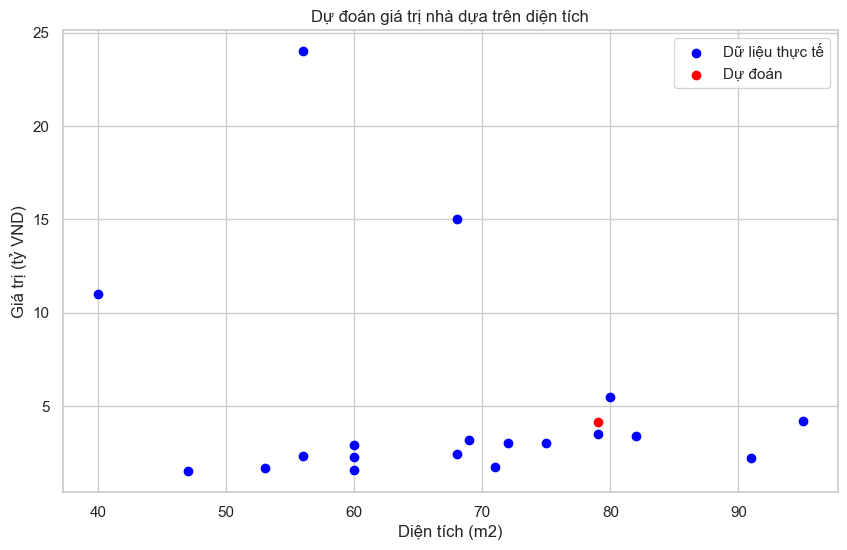

In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model = LinearRegression()
model.fit(X_train, y_train)
# Get the coefficients
coefficients = model.coef_
intercept = model.intercept_
# Dự đoán giá trị cho 1 ngôi nhà có diện tích 79m2, 2 phòng ngủ và cách TT 26.5km
house_features = np.array([79, 2, 26.5]).reshape(1, -1)
predicted_price_sklearn = model.predict(house_features)
print(f"Dự đoán giá trị: {predicted_price_sklearn[0]:.2f} tỷ VND")

# Vẽ đồ thị
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.scatter(df['Dien tich (m2)'], df['Gia (ty VND)'], color='blue', label='Dữ liệu thực tế')
plt.scatter(house_features[:, 0], predicted_price_sklearn, color='red', label='Dự đoán')
plt.title('Dự đoán giá trị nhà dựa trên diện tích')
plt.xlabel('Diện tích (m2)')
plt.ylabel('Giá trị (tỷ VND)')
plt.legend()
plt.show()

In [7]:
df = pd.read_csv('bang can nang chieu cao.csv')
df.set_index('STT', inplace=True)
df

,Chieu cao (cm),Can nang (kg)
STT,,
1,147,49
2,150,50
3,153,51
4,155,52
5,158,54
6,160,56
7,163,58
8,168,60
9,170,72


In [8]:
# Phương pháp đạo hàm mất mát
X = df['Chieu cao (cm)'].values
y = df['Can nang (kg)'].values
X_b = np.c_[np.ones((X.shape[0], 1)), X]
theta = svd_decomposition(X_b, y)
height = np.array([1, 170])
predicted_weight = height.dot(theta)
print("Giá trị dự đoán được là:", predicted_weight)

Giá trị dự đoán được là: 62.11247950738222


In [9]:
# Gradient descent
scaler = StandardScaler()
X_reshaped = X.reshape(-1, 1)
X_scaled = scaler.fit_transform(X_reshaped)
X_b = np.c_[np.ones((X_scaled.shape[0], 1)), X_scaled]
initial_theta = np.zeros(X_b.shape[1])
height = np.array([1, 170])
scaled_height = scaler.transform(height[1].reshape(-1, 1))
scaled_height = np.c_[np.ones((scaled_height.shape[0], 1)), scaled_height]
theta = gradient_descent(X_b, y, initial_theta, 0.001, 1000, 1e-2)
predicted_weight = scaled_height.dot(theta)
print("Giá trị dự đoán được là:", predicted_weight[0], "kg")

Giá trị dự đoán được là: 62.111748207679234 kg


In [10]:
# Accelerated gradient descent
theta = accelerated_gradient_descent(X_b, y, initial_theta, 0.001, 1000, 1e-2)
predicted_weight = scaled_height.dot(theta)
print("Giá trị dự đoán được là:", predicted_weight[0], "kg")

Giá trị dự đoán được là: 62.112028462718776 kg


In [11]:
# Stochastic gradient descent
theta = stochastic_gradient_descent(X_b, y, initial_theta, 0.001, 10000, 1e-2)
predicted_weight = scaled_height.dot(theta)
print("Giá trị dự đoán được là:", predicted_weight[0], "kg")

Giá trị dự đoán được là: 61.09997598585316 kg
 61.09997598585316 kg


Dự đoán giá trị: 62.33 kg


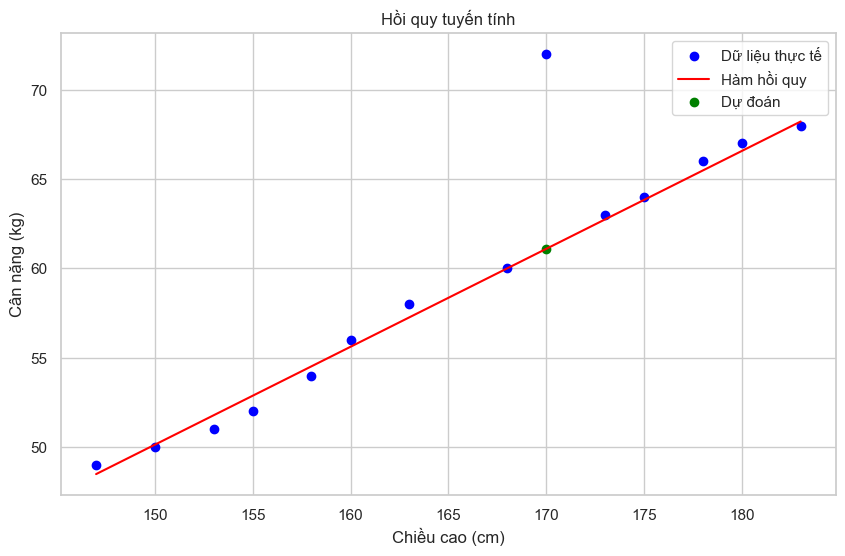

In [12]:
# Using sklearn
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
coefficients = model.coef_
intercept = model.intercept_
height = np.array([170]).reshape(1, -1)
predicted_weight_sklearn = model.predict(height)
print(f"Dự đoán giá trị: {predicted_weight_sklearn[0]:.2f} kg")

# Vẽ đồ thị
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Dữ liệu thực tế')
plt.plot(X, X_b.dot(theta), color='red', label='Hàm hồi quy')
plt.scatter(height[0], predicted_weight, color='green', label='Dự đoán')
plt.title('Hồi quy tuyến tính')
plt.xlabel('Chiều cao (cm)')
plt.ylabel('Cân nặng (kg)')
plt.legend()
plt.show()